# BNH Benchmark
## Imports

In [ ]:
import os
import warnings

import matplotlib.pyplot as plt
import pandas as pd

import bofire.strategies.api as strategies
from bofire.benchmarks.api import BNH
from bofire.data_models.api import Domain, Inputs, Outputs
from bofire.data_models.features.api import ContinuousInput, ContinuousOutput
from bofire.data_models.objectives.api import (
    MaximizeSigmoidObjective,
    MinimizeObjective,
    MinimizeSigmoidObjective,
)
from bofire.data_models.strategies.api import MoboStrategy, RandomStrategy
from bofire.plot.api import plot_objective_plotly
from bofire.runners.api import run
from bofire.utils.multiobjective import compute_hypervolume


warnings.simplefilter("once")
SMOKE_TEST = os.environ.get("SMOKE_TEST")

## Random Strategy

In [ ]:
def sample(domain):
    datamodel = RandomStrategy(domain=domain)
    sampler = strategies.map(data_model=datamodel)
    sampled = sampler.ask(10)
    return sampled


def hypervolume(domain: Domain, experiments: pd.DataFrame) -> float:
    if "c1" in experiments.columns:
        return compute_hypervolume(
            domain,
            experiments.loc[(experiments.c1 <= 25) & (experiments.c2 >= 7.7)],
            ref_point={"f1": 140, "f2": 50},
        )
    else:
        return compute_hypervolume(domain, experiments, ref_point={"f1": 140, "f2": 50})


random_results = run(
    BNH(constraints=True),
    strategy_factory=lambda domain: strategies.map(RandomStrategy(domain=domain)),
    n_iterations=50 if not SMOKE_TEST else 1,
    metric=hypervolume,
    initial_sampler=sample,
    n_runs=1,
    n_procs=1,
)

Run 0: 100%|██████████| 50/50 [00:01<00:00, 45.90it/s, Current Best:=5069.054]


## MOBO Strategy
### Without Constraints

In [ ]:
def strategy_factory(domain: Domain):
    data_model = MoboStrategy(domain=domain, ref_point={"f1": 140, "f2": 50})
    return strategies.map(data_model)


results = run(
    BNH(constraints=False),
    strategy_factory=strategy_factory,
    n_iterations=50 if not SMOKE_TEST else 1,
    metric=hypervolume,
    initial_sampler=sample,
    n_runs=1,
    n_procs=1,
)

Run 0: 100%|██████████| 50/50 [16:46<00:00, 20.12s/it, Current Best:=5240.688]


### With Constraints

#### Manual Setup of the Domain

In [ ]:
domain = Domain(
    inputs=Inputs(
        features=[
            ContinuousInput(key="x1", bounds=(0, 5)),
            ContinuousInput(key="x2", bounds=(0, 3)),
        ]
    ),
    outputs=Outputs(
        features=[
            ContinuousOutput(key="f1", objective=MinimizeObjective()),
            ContinuousOutput(key="f2", objective=MinimizeObjective()),
            # these are the output constraints, choose MinimizeSigmoidObjective for lower bound constraints
            # and MaximizeSigmoidObjective for upper bound constraints
            # tp is the threshold point, steepness is the steepness of the sigmoid that is applied to the constraint
            # usually a steepness of 1000 is fine.
            ContinuousOutput(
                key="c1",
                objective=MinimizeSigmoidObjective(tp=25, steepness=1000),
            ),
            ContinuousOutput(
                key="c2",
                objective=MaximizeSigmoidObjective(tp=7.7, steepness=1000),
            ),
        ]
    ),
)

One can visualize the objectives in the following way:

In [ ]:
feat = domain.outputs.get_by_key("c1")

if not SMOKE_TEST:
    plot_objective_plotly(feat, lower=20, upper=30)  # type: ignore

/Users/radical-rhys/miniconda/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
feat = domain.outputs.get_by_key("c2")

if not SMOKE_TEST:
    plot_objective_plotly(feat, lower=5, upper=10)  # type: ignore

/Users/radical-rhys/miniconda/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

overflow encountered in exp



#### Run tbe optimization
The warnings can be ignored. They are stemming just from an internal postprocessing step and will be removed soon.

In [ ]:
c_results = run(
    BNH(constraints=True),
    strategy_factory=strategy_factory,
    n_iterations=50 if not SMOKE_TEST else 1,
    metric=hypervolume,
    initial_sampler=sample,
    n_runs=1,
    n_procs=1,
)

  0%|          | 0/50 [00:00<?, ?it/s]/Users/radical-rhys/miniconda/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

overflow encountered in exp

Run 0:   2%|▏         | 1/50 [00:11<09:47, 12.00s/it, Current Best:=4809.159]/Users/radical-rhys/miniconda/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

overflow encountered in exp

Run 0:   4%|▍         | 2/50 [00:23<09:09, 11.45s/it, Current Best:=4888.335]/Users/radical-rhys/miniconda/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

overflow encountered in exp

Run 0:   6%|▌         | 3/50 [00:35<09:12, 11.75s/it, Current Best:=4934.845]/Users/radical-rhys/miniconda/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

overflow encountered in exp

Run 0:   8%|▊         | 4/50 [00:47<09:11, 11.99s/it, Current Best:=4983.264]/Users/radical-rhys/miniconda/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

overflow

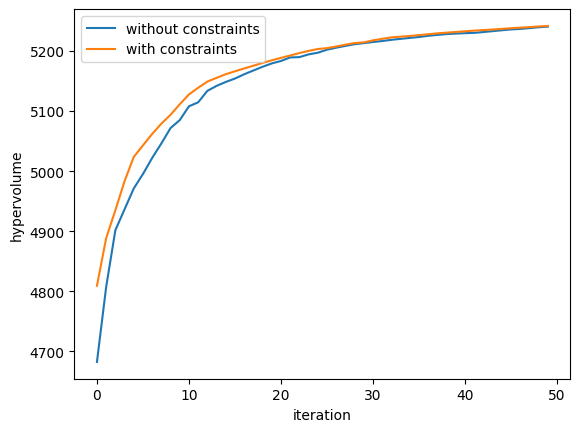

In [ ]:
if not SMOKE_TEST:
    fig, ax = plt.subplots()
    ax.plot(results[0][1], label="without constraints")
    ax.plot(c_results[0][1], label="with constraints")
    ax.set_xlabel("iteration")
    ax.set_ylabel("hypervolume")
    ax.legend()
    plt.show()